# Utils

In [ ]:
!pip install scikit-learn==0.20.3 scipy==1.4.1 xgboost==0.82

     |████████████████████████████████| 5.4 MB 6.6 MB/s 
     |████████████████████████████████| 114.0 MB 21 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.3 which is incompatible.


In [ ]:
from google.colab import drive
import re
import os
import pandas as pd
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle

import IPython.display
import librosa.display
ms.use('seaborn-muted')

import math
import random

import xgboost as xgb

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
/usr/

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Configs

In [ ]:
model_config = {
    'gpu': 0,
    'bidirectional': False,
    'input_dim': 8,
    'hidden_dim': 50,
    'output_dim': 4,  # number of classes
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 1567,  # carefully chosen
    'n_epochs': 55000,
    'n_layers': 2,
    'model_code': 'basic_lstm'
}


## ENV Variables

In [ ]:
IEMOCAP_PATH = '/content/gdrive/MyDrive/Major Project Sem 7 8/IEMOCAP_full_release_withoutVideos/IEMOCAP_full_release/Session'
DATA_PREPROCESSED_PATH = '/content/multimodal-speech-emotion-recognition/data/pre-processed/'

# Mounting Google Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Creating necessary directories

In [ ]:
!mkdir /content/multimodal-speech-emotion-recognition
!mkdir /content/multimodal-speech-emotion-recognition/data
!mkdir /content/multimodal-speech-emotion-recognition/data/pre-processed
!mkdir /content/multimodal-speech-emotion-recognition/data/s2e
!mkdir /content/multimodal-speech-emotion-recognition/data/t2e
!mkdir /content/multimodal-speech-emotion-recognition/runs
!mkdir /content/multimodal-speech-emotion-recognition/results
!mkdir /content/multimodal-speech-emotion-recognition/pred_probas

In [ ]:
# ! git clone https://github.com/Demfier/multimodal-speech-emotion-recognition.git

In [ ]:
%cd /content/multimodal-speech-emotion-recognition

/content/multimodal-speech-emotion-recognition


In [ ]:
# !pip install -r requirements.txt

In [ ]:
!ls "/content/gdrive/MyDrive/Major Project Sem 7 8/IEMOCAP_full_release_withoutVideos/IEMOCAP_full_release"

Documentation  README.txt~  Session2  Session4
README.txt     Session1     Session3  Session5


In [ ]:
# !pip install numpy --upgrade

# Extract Emotion Labels from the IEMOCAP dataset

In [ ]:
# # Extract labels from the evaluation files

# first testing with one file
file_path = '{}1/dialog/EmoEvaluation/Ses01F_impro01.txt'.format(IEMOCAP_PATH)



useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)




with open(file_path) as f:
    file_content = f.read()

info_lines = re.findall(useful_regex, file_content)




for l in info_lines[1:10]:
    print(l.strip().split('\t'))


# Compile all the information in a single file

info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '{}{}/dialog/EmoEvaluation/'.format(IEMOCAP_PATH,sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            if(emotion == 'fru'):
              emotions.append('ang')
            else:
              emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)


df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()


df_iemocap.to_csv('{}df_iemocap.csv'.format(DATA_PREPROCESSED_PATH), index=False)


['[6.2901 - 8.2357]', 'Ses01F_impro01_F000', 'neu', '[2.5000, 2.5000, 2.5000]']
['[10.0100 - 11.3925]', 'Ses01F_impro01_F001', 'neu', '[2.5000, 2.5000, 2.5000]']
['[14.8872 - 18.0175]', 'Ses01F_impro01_F002', 'neu', '[2.5000, 2.5000, 2.5000]']
['[19.2900 - 20.7875]', 'Ses01F_impro01_F003', 'xxx', '[2.5000, 3.0000, 3.0000]']
['[21.3257 - 24.7400]', 'Ses01F_impro01_F004', 'xxx', '[2.5000, 3.0000, 2.5000]']
['[27.4600 - 31.4900]', 'Ses01F_impro01_F005', 'neu', '[2.5000, 3.5000, 2.0000]']
['[38.9650 - 43.5900]', 'Ses01F_impro01_F006', 'fru', '[2.0000, 3.5000, 3.5000]']
['[46.5800 - 52.1900]', 'Ses01F_impro01_F007', 'fru', '[2.5000, 3.5000, 3.5000]']
['[56.1600 - 58.8225]', 'Ses01F_impro01_F008', 'fru', '[2.0000, 3.5000, 3.5000]']


# Building Audio Vectors of all the files in the dataset

In [ ]:
# Build Audio Vectors
# Now that the labels have been extracted, we'll use the compiled csv (df_iemocap.csv) to split the original wav files into multiple frames


# Trying for one file first

file_path = '{}1/dialog/wav/Ses01F_impro01.wav'.format(IEMOCAP_PATH)

y, sr = librosa.load(file_path, sr=44100)
y, sr


#Looping through all the files


import pandas as pd
import math

labels_df = pd.read_csv('{}df_iemocap.csv'.format(DATA_PREPROCESSED_PATH))

sr = 44100
audio_vectors = {}
for sess in range(1,4):  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}{}/dialog/wav/'.format(IEMOCAP_PATH, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('{}audio_vectors_{}.pkl'.format(DATA_PREPROCESSED_PATH,sess), 'wb') as f:
        pickle.dump(audio_vectors, f)


100%|██████████| 32/32 [06:32<00:00, 12.28s/it]


# Extracting Audio Features from Audio Signals

Signal mean = 0.01923
Signal std dev = 0.04892
RMSE mean = 0.02414
RMSE std dev = 0.04252
0.554858934169279


919it [20:16,  1.30s/it]

Some exception occured


1819it [42:21,  1.40s/it]
1811it [40:41,  1.35s/it]
217it [05:30,  1.89s/it]

Some exception occured


2136it [46:33,  1.31s/it]


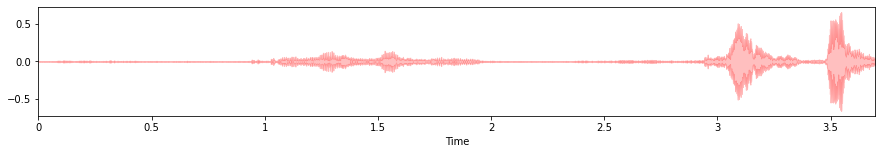

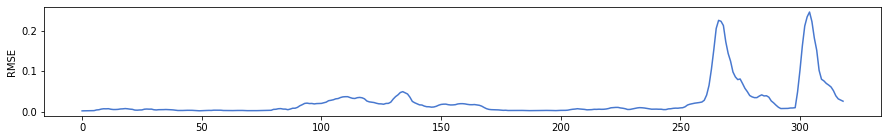

In [ ]:

labels_df_path = '{}df_iemocap.csv'.format(DATA_PREPROCESSED_PATH)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(DATA_PREPROCESSED_PATH)



labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))



random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100



plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')



print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))



rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))



from IPython.display import Audio
Audio(y, rate=44100)



silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))



y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)


autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)


cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)


columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)


# The following blocks build feature vectors for all the files

emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

labels_path = '{}df_iemocap.csv'.format(DATA_PREPROCESSED_PATH)
audio_vectors_path = '{}audio_vectors_'.format(DATA_PREPROCESSED_PATH)


labels_df = pd.read_csv(labels_path)

for sess in range(1,4): #for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                if(label in [2,4,5,6,8]): continue
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std

                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

df_features.to_csv('data/pre-processed/audio_features.csv', index=False)

In [ ]:
# !python 3_extract_audio_features.py

# Preparing Data for Training and Testing

In [ ]:
# ## Build Speech data files



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# get_ipython().run_line_magic('matplotlib', 'inline')



df = pd.read_csv('{}audio_features.csv'.format(DATA_PREPROCESSED_PATH))
df = df[df['label'].isin([0, 1, 2, 3, 4, 5, 6, 7, 8])]
print(df.shape)
display(df.head())

# change 7 to 2
# df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5})
df.head()


df.to_csv('/content/multimodal-speech-emotion-recognition/data/no_sample_df.csv')

# oversampling fear
fear_df = df[df['label']==3]
for i in range(30):
    df = df.append(fear_df)

sur_df = df[df['label']==4]
for i in range(10):
    df = df.append(sur_df)

df.to_csv('/content/multimodal-speech-emotion-recognition/data/modified_df.csv')



emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'neu': 3,}

# emotion_dict = {'ang': 0,
#                 'hap': 1,
#                 'exc': 2,
#                 'sad': 3,
#                 'fru': 4,
#                 'fea': 5,
#                 'sur': 6,
#                 'neu': 7,
#                 'xxx': 8,
#                 'oth': 8}
df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 4, 6: 4, 7: 3, 8:4})
df.drop(df.index[df['label']==4], inplace=True)
scalar = MinMaxScaler()
df[df.columns[2:]] = scalar.fit_transform(df[df.columns[2:]])
df.head()


x_train, x_test = train_test_split(df, test_size=0.20)

x_train.to_csv('/content/multimodal-speech-emotion-recognition/data/s2e/audio_train.csv', index=False)
x_test.to_csv('/content/multimodal-speech-emotion-recognition/data/s2e/audio_test.csv', index=False)

print(x_train.shape, x_test.shape)


# Defining preprocessing functions for text

import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


# ## Build Text data files

import re
import os
import pickle

useful_regex = re.compile(r'^(\w+)', re.IGNORECASE)

file2transcriptions = {}

for sess in range(1, 6):
    transcripts_path = '{}{}/dialog/transcriptions/'.format(IEMOCAP_PATH,sess)
    transcript_files = os.listdir(transcripts_path)
    for f in transcript_files:
        with open('{}{}'.format(transcripts_path, f), 'r') as f:
            all_lines = f.readlines()

        for l in all_lines:
            audio_code = useful_regex.match(l).group()
            transcription = l.split(':')[-1].strip()
            # assuming that all the keys would be unique and hence no `try`
            file2transcriptions[audio_code] = transcription
# save dict
with open('/content/multimodal-speech-emotion-recognition/data/t2e/audiocode2text.pkl', 'wb') as file:
    pickle.dump(file2transcriptions, file)
len(file2transcriptions)



audiocode2text = pickle.load(open('/content/multimodal-speech-emotion-recognition/data/t2e/audiocode2text.pkl', 'rb'))


# Prepare text data
text_train = pd.DataFrame()
text_train['wav_file'] = x_train['wav_file']
text_train['label'] = x_train['label']
text_train['transcription'] = [normalizeString(audiocode2text[code]) for code in x_train['wav_file']]

text_test = pd.DataFrame()
text_test['wav_file'] = x_test['wav_file']
text_test['label'] = x_test['label']
text_test['transcription'] = [normalizeString(audiocode2text[code]) for code in x_test['wav_file']]

text_train.to_csv('/content/multimodal-speech-emotion-recognition/data/t2e/text_train.csv', index=False)
text_test.to_csv('/content/multimodal-speech-emotion-recognition/data/t2e/text_test.csv', index=False)

print(text_train.shape, text_test.shape)

(3742, 10)


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01M_impro06_F000,7,0.003579,0.006817,0.004510,0.005104,0.008969,-0.009950,0.037187,0.120070
1,Ses01M_impro06_F001,7,0.002980,0.004733,0.003723,0.002918,0.000000,-0.008699,0.016005,0.057092
2,Ses01M_impro06_F002,7,0.004494,0.007062,0.005439,0.004501,0.075000,-0.005462,0.035227,0.171471
3,Ses01M_impro06_F003,3,0.003673,0.005732,0.004502,0.003538,0.024896,-0.004687,0.023078,0.105006
4,Ses01M_impro06_F004,3,0.005543,0.008848,0.006684,0.005794,0.265306,-0.008176,0.055909,0.262907


(19697, 10) (4925, 10)
(19697, 3) (4925, 3)


In [ ]:
# !python 4_prepare_data.py

In [ ]:
%cd /content/multimodal-speech-emotion-recognition

/content/multimodal-speech-emotion-recognition


# Classification of Audio using ML models

In [ ]:
# !python 5_audio_classification.py

(19697, 10)
(19697, 10) (4925, 10)
{2: 17238, 0: 1298, 3: 851, 1: 310}
LENGTH  (4925, 4)
********** 
RANDOM FOREST
 **********
Test Set Accuracy =  0.934
Test Set F-score =  0.484
Test Set Precision =  0.533
Test Set Recall =  0.485
Confusion matrix, without normalization
[[ 215    0   57   23]
 [  48    0   21    8]
 [   0    0 4338    0]
 [ 113    0   57   45]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********** 
XGBoost
 **********
Test Set Accuracy =  0.926
Test Set F-score =  0.466
Test Set Precision =  0.514
Test Set Recall =  0.452
Confusion matrix, without normalization
[[ 178    4   81   32]
 [  39    0   29    9]
 [   0    0 4338    0]
 [  89    1   81   44]]
********** 
MLP
 **********
Test Set Accuracy =  0.909
Test Set F-score =  0.388
Test Set Precision =  0.463
Test Set Recall =  0.374
Confusion matrix, without normalization
[[ 142    0  150    3]
 [  25    0   49    3]
 [   4    0 4329    5]
 [  43    0  168    4]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********** SVM Classifier
 **********
Test Set Accuracy =  0.909
Test Set F-score =  0.388
Test Set Precision =  0.463
Test Set Recall =  0.374
Confusion matrix, without normalization
[[ 142    0  150    3]
 [  25    0   49    3]
 [   4    0 4329    5]
 [  43    0  168    4]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********** 
Multi Naive Bayes
 **********
Test Set Accuracy =  0.882
Test Set F-score =  0.241
Test Set Precision =  0.470
Test Set Recall =  0.253
Confusion matrix, without normalization
[[   4    0  291    0]
 [   0    0   77    0]
 [   0    0 4338    0]
 [   0    0  215    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********** 
Logistic Regression
 **********
Test Set Accuracy =  0.889
Test Set F-score =  0.319
Test Set Precision =  0.362
Test Set Recall =  0.308
Confusion matrix, without normalization
[[  70    0  225    0]
 [  14    0   63    0]
 [  29    0 4309    0]
 [  14    0  201    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Stats for top 3 features:
********** 
For top 3 features XGB Classifier
 **********
Test Set Accuracy =  0.919
Test Set F-score =  0.423
Test Set Precision =  0.519
Test Set Recall =  0.412
Stats for top 5 features:
********** 
For top 5 features XGB Classifier
 **********
Test Set Accuracy =  0.921
Test Set F-score =  0.442
Test Set Precision =  0.520
Test Set Recall =  0.425
Stats for top 6 features:
********** 
For top 6 features XGB Classifier
 **********
Test Set Accuracy =  0.920
Test Set F-score =  0.441
Test Set Precision =  0.519
Test Set Recall =  0.424
Stats for top 7 features:
********** 
For top 7 features XGB Classifier
 **********
Test Set Accuracy =  0.927
Test Set F-score =  0.471
Test Set Precision =  0.539
Test Set Recall =  0.455
Stats for top 8 features:
********** 
For top 8 features XGB Classifier
 **********
Test Set Accuracy =  0.926
Test Set F-score =  0.466
Test Set Precision =  0.514
Test Set Recall =  0.452


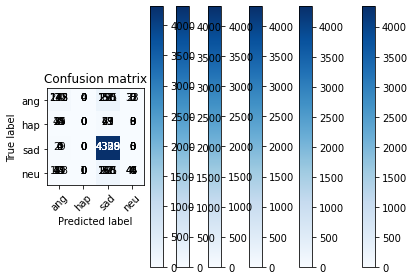

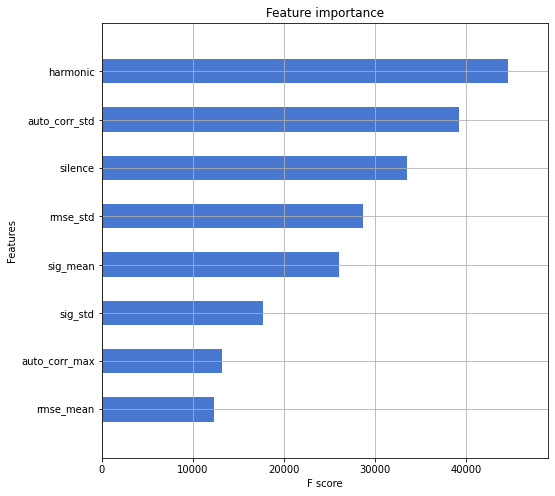

In [ ]:

# from IPython.display import display

# get_ipython().run_line_magic('matplotlib', 'inline')


x_train = pd.read_csv('/content/multimodal-speech-emotion-recognition/data/s2e/audio_train.csv')
x_test = pd.read_csv('/content/multimodal-speech-emotion-recognition/data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']


print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']



emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'neu': 3}

emo_keys = list(['ang', 'hap', 'sad', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)



rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)
print("LENGTH ",pred_probs.shape)
# Results
print("*"*10,"\nRANDOM FOREST\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.model', 'wb') as f:
    pickle.dump(rf_classifier, f)



xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emo_keys),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
print("*"*10,"\nXGBoost\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.model', 'wb') as f:
    pickle.dump(xgb_classifier, f)



mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
print("*"*10,"\nMLP\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.model', 'wb') as f:
    pickle.dump(mlp_classifier, f)



svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
print("*"*10,"SVM Classifier\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.model', 'wb') as f:
    pickle.dump(svc_classifier, f)



mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
print("*"*10,"\nMulti Naive Bayes\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.model', 'wb') as f:
    pickle.dump(mnb_classifier, f)


lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
print("*"*10,"\nLogistic Regression\n","*"*10)
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.model', 'wb') as f:
    pickle.dump(lr_classifier, f)



ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)



contribution_scores = xgb_classifier.feature_importances_
contribution_scores




top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)

    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    print("*"*10,"\nFor top {} features XGB Classifier\n".format(n),"*"*10)

    display_results(y_test, pred_probs, cm = False)


# Load predicted probabilities
# with open('/content/multimodal-speech-emotion-recognition/pred_probas/rf_classifier.pkl', 'rb') as f:
#     rf_pred_probs = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/xgb_classifier.pkl', 'rb') as f:
#     xgb_pred_probs = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/svc_classifier_model.pkl', 'rb') as f:
#     svc_preds = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/mnb_classifier.pkl', 'rb') as f:
#     mnb_pred_probs = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/mlp_classifier.pkl', 'rb') as f:
#     mlp_pred_probs = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/lr_classifier.pkl', 'rb') as f:
#     lr_pred_probs = pickle.load(f)

# with open('/content/multimodal-speech-emotion-recognition/pred_probas/lstm_classifier.pkl', 'rb') as f:
#     lstm_pred_probs = pickle.load(f)

# # Average of the predicted probabilites
# ensemble_pred_probs = (xgb_pred_probs +
#                        mlp_pred_probs +
#                        rf_pred_probs)/3.0
# # Show metrics
# print("*"*10,"\nEnsemble : (XGB + MLP + RF + MNB + LR) Average\n","*"*10)

# display_results(y_test, ensemble_pred_probs)

